# GEO1001
## Assignment 2 
### Name: Pratyush
### Student Number: 5359252

>You have to classify 2 resolutions:

>1. The whole **60m** image
>2. A **subset** of the **10m** (use rasterio.window)

>These 2 might require different parameters, it is up to you to tell me.



## Imports
### Imports required: rasterio, matplotlib , seaborn, os, numpy, sklearn    


In [1]:
import rasterio 
from rasterio import plot # for plotting datasets, may not be of use
from rasterio.plot import show_hist # for showing histogram distribution of bands in a daatset, may not be of use
from rasterio.windows import Window , from_bounds, crop# for clipping out only a window from dataset use in part 2
import matplotlib.pyplot as plt #for plotting images
import numpy as np # for doing computations
import os  # to read file paths to the image data
from sklearn import cluster
%matplotlib inline

# 1. Introduction
In order to be run an unsupervised classification on sentinel images, we need to define 2 things:

1. The clustering algorithm to be chosen for the unsupervised classification
2. The number of bands to be used for the classification, and
3. The number of clusters to be made for the clustering algorithm

This study will explore the above research questions by running different clustering algorithms on 60m and 10m datasets from Sentinel-2 images. The dataset can be downloaded from [this link.](https://3d.bk.tudelft.nl/courses/geo1001/data/S2A_MSIL2A_20200530T105031_N0214_R051_T31UET_20200530T134211.zip) 

## 1.1 Hypothesis:
* Larger number of bands taken for classification should return better results though a tradeoff with the processing time taken for clustering.
* Since data is of a country with most possible landcovers of 
    * Urban built up 
    * Green cover
    * sandy areas
    * water bodies
    * barren land 
    * moist soil
* with higher number of clusters the resulting classified image should generate more noise, bringing more classes which may address classes like waterlogged agricultural field, or urban builtup mixed with green cover, especially in 10m dataset where the cells may cover areas which have a mixture of built up and green cover, and similar results for boulevards.


Finally this study discusses the differences in the clusters created with 60m and 10m data. Usually higher resolution datasets tend to be more difficult to cluster than low resolution datasets. These research questions and hypothesis will be tested in the document that follows.

# 2. Sentinel 2 imagery
The Sentinel-2 mission is a land monitoring constellation of two satellites[[1]](https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/sentinel-2) that provide high resolution optical imagery. The images captured contain 12 different bands taken at 3 different resolutions, 10m, 20m, and 60m.
The table below summarises the bands captured and their spatial resolution:

Table of bands and respective resolutions

| Band 	| Resolution 	| Central Wavelength 	|            Description           	|
|:----:	|:------------:	|:--------------------:	|:--------------------------------:	|
| B1   	| 60 m       	| 443 nm             	| Ultra blue (Coastal and Aerosol) 	|
| B2   	| 10 m       	| 490 nm             	| Blue                             	|
| B3   	| 10 m       	| 560 nm             	| Green                            	|
| B4   	| 10 m       	| 665 nm             	| Red                              	|
| B5   	| 20 m       	| 705 nm             	| vegetation and red edge (VNIR) 	|
| B6   	| 20 m       	| 740 nm             	| vegetation and red edge (VNIR) 	|
| B7   	| 20 m       	| 783 nm             	| vegetation and red edge (VNIR) 	|
| B8   	| 10 m       	| 842 nm             	| Near Infrared (NIR) for FCC    	|
| B8a  	| 20 m       	| 865 nm             	| Narrow Near Infrared (VNIR) 	    |
| B9   	| 60 m       	| 940 nm             	| Water Vapour                  	|
| B10  	| 60 m       	| 1375 nm            	| Short Wave Infrared (SWIR): cirrus       	|
| B11  	| 20 m       	| 1610 nm            	| Short Wave Infrared (SWIR)       	|
| B12  	| 20 m       	| 2190 nm            	| Short Wave Infrared (SWIR)       	|


# 3. Clustering 60m datasets
This section explores the clustering of 60m datasets of Sentinel 2. Firstly, the datasets are clustered using k-means clustering algorithm using all bands, following which the clustering is done using only 3bands, and the differences are analysed.

For the workflow, 
* path = path to all images 
* stackpath = list of all paths of required bands 
* ds = list of datasets for such bands
* combined_arr = all bands stacked as np arrays

[k-means-sentinel-2-python](http://www.acgeospatial.co.uk/k-means-sentinel-2-python/)


## 3.1 60m dataset, all bands used for clustering using K-Means
### 3.1.1 Processing datasets for clustering

In [6]:
path_60 = R'./GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m'
l = os.listdir(path_60)
tostack = l[1:12] #take bands 1 to 12 for 60m dataset
stackpath = [os.path.join(path_60,i) for i in tostack]
ds = [rasterio.open( stackpath[i] , driver='JP2OpenJPEG') for i in  range(len( stackpath ))] # list of datasets    

combined_arr = np.zeros( ds[0].read(1).shape , dtype='int32')

for i in range( len(ds) ):
    if i==0:
        combined_arr += np.array(ds[i].read(1) , dtype='int32' ) 
    else:
        combined_arr = np.dstack((combined_arr , np.array(ds[i].read(1) , dtype='int32' ))  )   
    ds[i].close()

del ds

#ds data is open, should close for better memory management
new_shape = (combined_arr.shape[0] * combined_arr.shape[1], combined_arr.shape[2])
reshaped_arr_4_kMeans = combined_arr[:, :, :].reshape(new_shape)
reshaped_arr_4_kMeans


array([[ 288,  289,  185, ...,   66,   61,   75],
       [ 387,  294,  192, ...,   67,   68,   81],
       [ 368,  299,  193, ...,   66,   68,   75],
       ...,
       [ 395,  513,  754, ..., 2673, 1731, 2397],
       [ 419,  415,  621, ..., 2403, 1533, 2232],
       [ 342,  621,  881, ..., 3010, 2029, 2429]], dtype=int32)

### 3.1.2 K-means clustering
K means is run on all bands of 60m data in this section

In [19]:
k_start = 5
k_end =   10

ds = rasterio.open( stackpath[0] , driver='JP2OpenJPEG')
c = ds.crs
trans = ds.transform
ds.close()
del ds

if not os.path.exists('./exports/k_means/60m'):
    os.makedirs('./exports/k_means/60m')

for i in range(  k_start  ,  k_end + 1  ):
    k_means = cluster.KMeans(n_clusters= i )
    k_means.fit(reshaped_arr_4_kMeans)

    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(combined_arr[:, :, 0].shape)
    
    
    save_dim = X_cluster.shape
    
    comp = rasterio.open('./exports/k_means/60m/km_60m_{}.tiff'.format(i),'w', 
                        driver='Gtiff', 
                        height = int(save_dim[0]), 
                        width = int(save_dim[1]), 
                        count= 1,
                        dtype = X_cluster.dtype, 
                        crs= c, 
                        transform = trans
                        )
    comp.write( X_cluster , 1) 
    comp.close()   


KeyboardInterrupt: 

### 3.1.3 Plotting clustered images

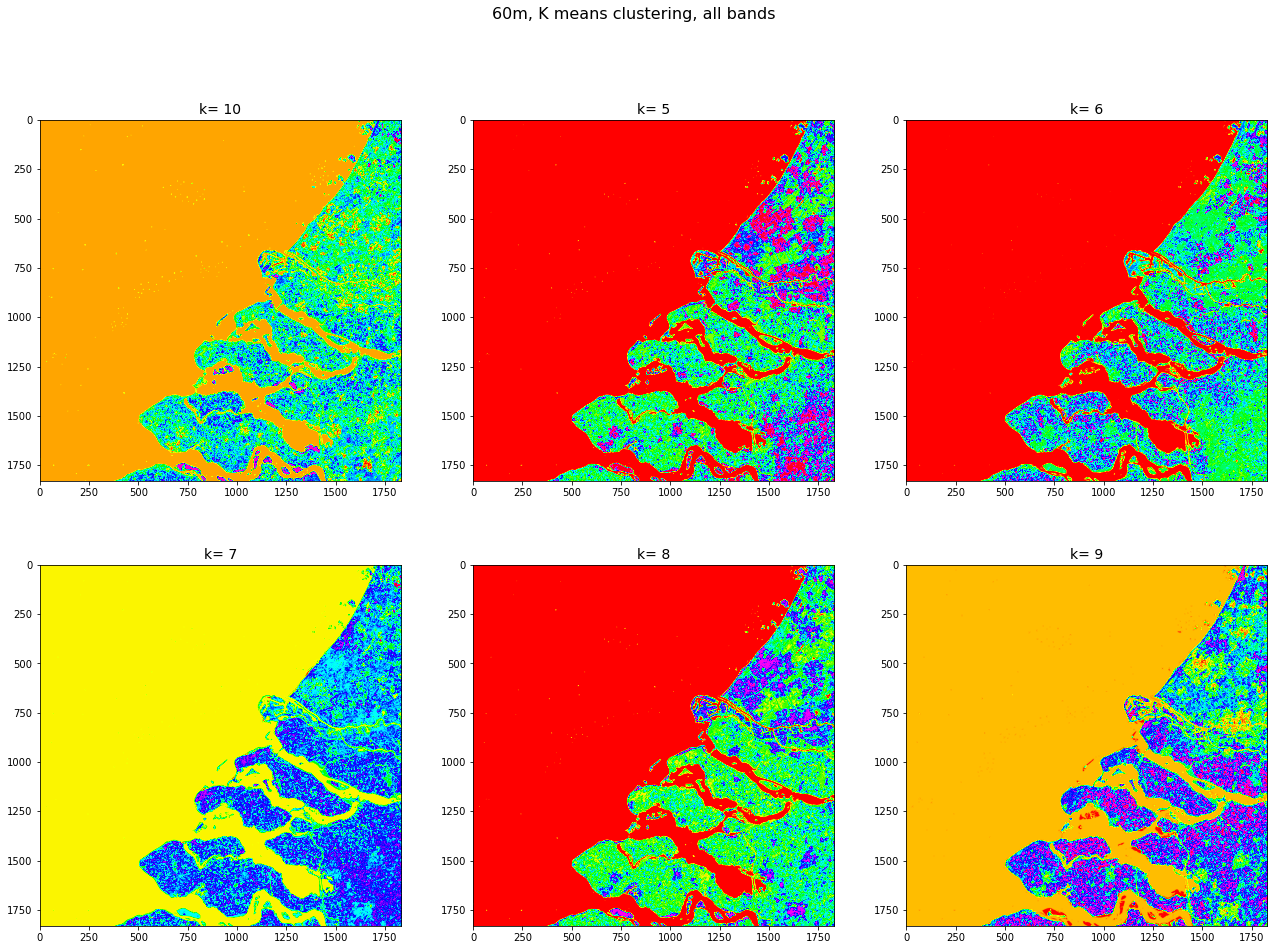

In [2]:
k_path = [os.path.join('./exports/k_means/60m' , i) for i in os.listdir('./exports/k_means/60m') if i.endswith('.tiff')]
f , axs = plt.subplots(2,3 , figsize=(22,15))
for _ in range(len(k_path)):
    filenm = k_path[_].split('/')[-1].split('_')[2].strip('.tiff')
    img = rasterio.open(k_path[_], driver='GTiff')
    if _ <3:
        axs[0][_].imshow(img.read(1) , cmap='hsv')
        axs[0][_].set_title('k= {}'.format(filenm) , fontsize='14') 
    else:
        axs[1][_ - 3].imshow(img.read(1) , cmap='hsv')
        axs[1][_ - 3].set_title('k= {}'.format(filenm) , fontsize='14')
    img.close()
    del img 
plt.suptitle('60m, K means clustering, all bands', fontsize='16')
plt.show()    


## 3.2 60m dataset, 3 bands used for clustering using K-Means
### 3.2.1 Processing 60m data with 3 bands for clustering
bands used:  3,4,8

In [ ]:
new_list = l[3:5]
new_list.append(l[11])
tostack = new_list #take bands 3,4,8 for 60m dataset
stackpath = [os.path.join(path_60,i) for i in tostack]
ds = [rasterio.open( stackpath[i] , driver='JP2OpenJPEG') for i in  range(len( stackpath ))] # list of datasets    

npa = np.zeros( ds[0].read(1).shape , dtype='int32')

for i in range( len(ds) ):
    if i==0:
        npa += np.array(ds[i].read(1) , dtype='int32' ) 
    else:
        npa = np.dstack((npa , np.array(ds[i].read(1) , dtype='int32' ))  )   
    ds[i].close()

del ds

#ds data is open, should close for better memory management
new_shape = (npa.shape[0] * npa.shape[1], npa.shape[2])
haha = npa[:, :, :].reshape(new_shape)
haha


### 3.2.2 K Means clustering on 3 bands 60m data

In [8]:
k_start = 5
k_end =   10

ds = rasterio.open( stackpath[0] , driver='JP2OpenJPEG')
c = ds.crs
trans = ds.transform
ds.close()
del ds

if not os.path.exists('./exports/k_means/60m_3bands'):
    os.makedirs('./exports/k_means/60m_3bands')

for i in range(  k_start  ,  k_end + 1  ):
    k_means = cluster.KMeans(n_clusters= i )
    k_means.fit(haha)

    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(npa[:, :, 0].shape)
    
    
    save_dim = X_cluster.shape
    
    comp = rasterio.open('./exports/k_means/60m_3bands/km_60m_{}.tiff'.format(i),'w', 
                        driver='Gtiff', 
                        height = int(save_dim[0]), 
                        width = int(save_dim[1]), 
                        count= 1,
                        dtype = X_cluster.dtype, 
                        crs= c, 
                        transform = trans
                        )
    comp.write( X_cluster , 1) 
    comp.close()   

### 3.2.3 Plotting K means clustered data with 3 bands, 60m

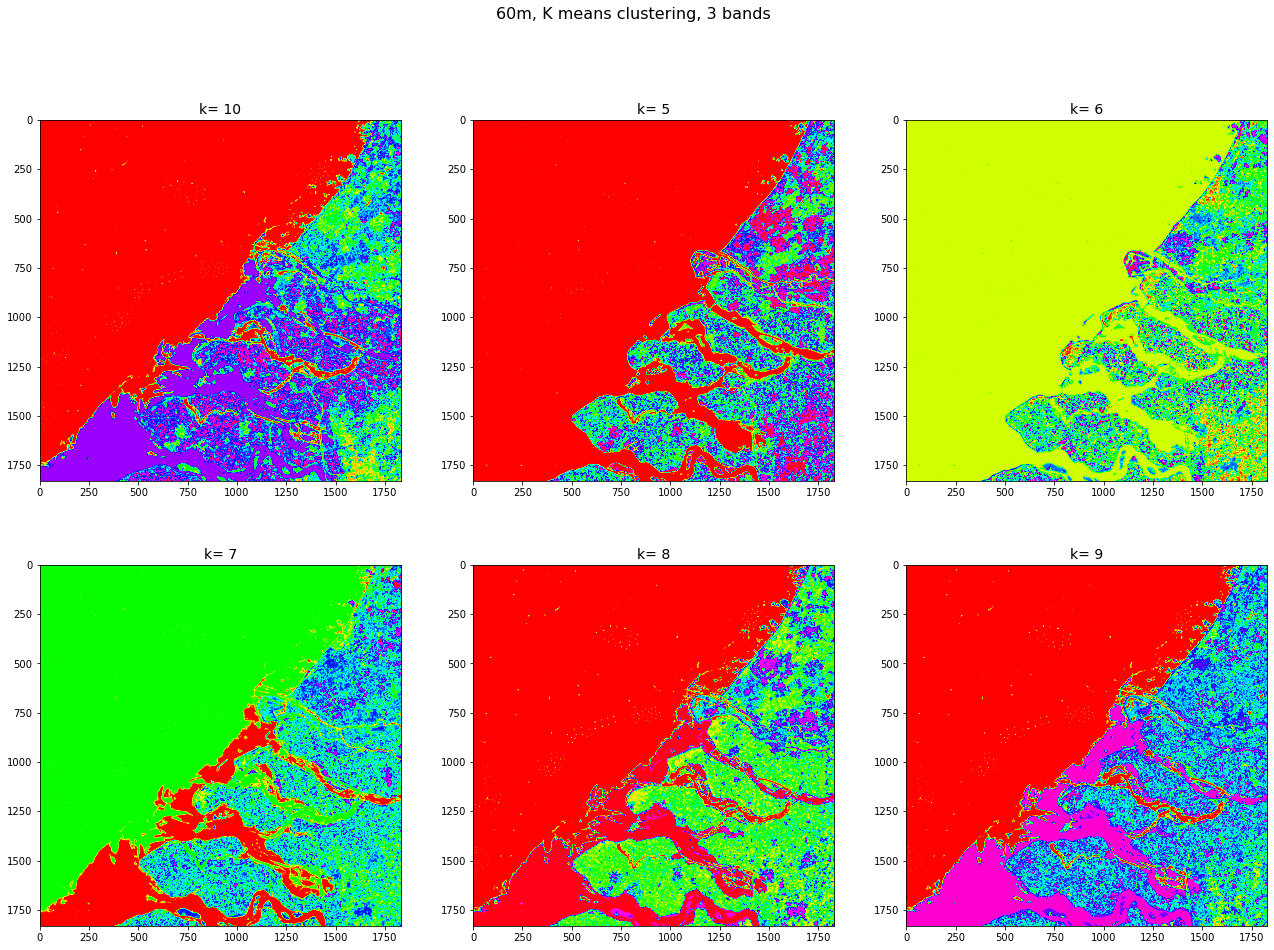

In [9]:
k_path = [os.path.join('./exports/k_means/60m_3bands' , i) for i in os.listdir('./exports/k_means/60m_3bands') if i.endswith('.tiff')]
f , axs = plt.subplots(2,3 , figsize=(22,15))
for _ in range(len(k_path)):
    filenm = k_path[_].split('/')[-1].split('_')[2].strip('.tiff')
    img = rasterio.open(k_path[_], driver='GTiff')
    if _ <3:
        axs[0][_].imshow(img.read(1) , cmap='hsv')
        axs[0][_].set_title('k= {}'.format(filenm) , fontsize='14') 
    else:
        axs[1][_ - 3].imshow(img.read(1) , cmap='hsv')
        axs[1][_ - 3].set_title('k= {}'.format(filenm) , fontsize='14')
    img.close()
    del img 
plt.suptitle('60m, K means clustering, 3 bands', fontsize='16')
plt.show()    


## 3.3 Conclusion
lorem

ipsum

dora

mifa

sola

tido


comparing plots for both 3 bands and 12 bands simultaneously

clustering with LWM, MNDWI, NDVI, EVI

# 4. Clustering 10 meter dataset 
This section explores the clustering of a subset of 10m  Sentinel 2 datasets. Firstly, the datasets subsetted using the Window() function from rasterio.window which accepts row and column offset in pixels. In order to convert the coordinates to pixel walues dataset.index() was used. The images are clustered using k-means clustering algorithm using all bands in 10m data.

For the workflow,

path = path to all images
stackpath = list of all paths of required bands
ds = list of datasets for such bands
combined_arr = all bands stacked as np arrays


### 4.1 Processing datasets for clustering

* subset of 10 m datasets 
* with top left coordinate as 601200.0 , 5773695.0 and width , height as 700,500
* bands used: 2,3,4,8


In [11]:
path_10 =  R'./GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R10m'
l_10 = os.listdir(path_10)
tostack_10 = l_10[1:5] #take bands B G R NIR for 10m data
stackpath_10 = [os.path.join(path_10,i) for i in tostack_10]
ds_10 = [rasterio.open( stackpath_10[i], driver='JP2OpenJPEG' ) for i in  range(len( stackpath_10 ))] # list of datasets    
r,c= ds_10[0].index( 601200.0 , 5773695.0 )

window_= Window( col_off=c , row_off= r ,width= 700,height= 500)

bands_10=  np.zeros( ds_10[0].read(1 , window=window_).shape , dtype='int32') #array holding all bands as numpy arrays 

for i in range( len(ds_10) ):
    if i==0:
        bands_10 += np.array(ds_10[i].read(1, window=window_) , dtype='int32' ) 
    else:
        bands_10 = np.dstack((bands_10 , np.array(ds_10[i].read(1, window=window_) , dtype='int32' ))  )   
    ds_10[i].close()

del ds_10

print(bands_10.shape)

new_shape = (bands_10.shape[0] * bands_10.shape[1], bands_10.shape[2])
newarr_10 = bands_10[:, :, :].reshape(new_shape)
newarr_10

(500, 700, 4)


array([[ 380,  791,  489, 4240],
       [ 316,  706,  449, 3564],
       [ 373,  771,  504, 4046],
       ...,
       [ 515,  802,  508, 4792],
       [ 515,  793,  518, 4804],
       [ 495,  767,  526, 4712]], dtype=int32)

```python
npa = np.zeros( ds[0].read(1).shape , dtype='int32')

for i in range( len(ds) ):
    if i==0:
        npa += np.array(ds[i].read(1) , dtype='int32' ) 
    else:
        npa = np.dstack((npa , np.array(ds[i].read(1) , dtype='int32' ))  )   
    ds[i].close()

del ds

#ds data is open, should close for better memory management
new_shape = (npa.shape[0] * npa.shape[1], npa.shape[2])
haha = npa[:, :, :].reshape(new_shape)
haha
```

## 4.2 K means clusttering for 10m dataset

In [26]:
k_start = 5
k_end =   10

ds = rasterio.open( stackpath[0] , driver='JP2OpenJPEG')
c = ds.crs
trans = ds.transform
ds.close()
del ds


if not os.path.exists('./exports/k_means/10m'):
    os.makedirs('./exports/k_means/10m')

for i in range(  k_start  ,  k_end + 1  ):
    k_means = cluster.KMeans(n_clusters= i )
    k_means.fit(newarr_10)

    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(bands_10[:, :, 0].shape)
    
    
    save_dim = X_cluster.shape
    
    comp = rasterio.open('./exports/k_means/10m/km_10_{}.tiff'.format(i),'w', 
                        driver='Gtiff', 
                        height = int(save_dim[0]), 
                        width = int(save_dim[1]), 
                        count= 1,
                        dtype = X_cluster.dtype, 
                        crs= c, 
                        transform = trans
                        )
    comp.write( X_cluster , 1) 
    comp.close()   


## 4.3 Plotting classified image

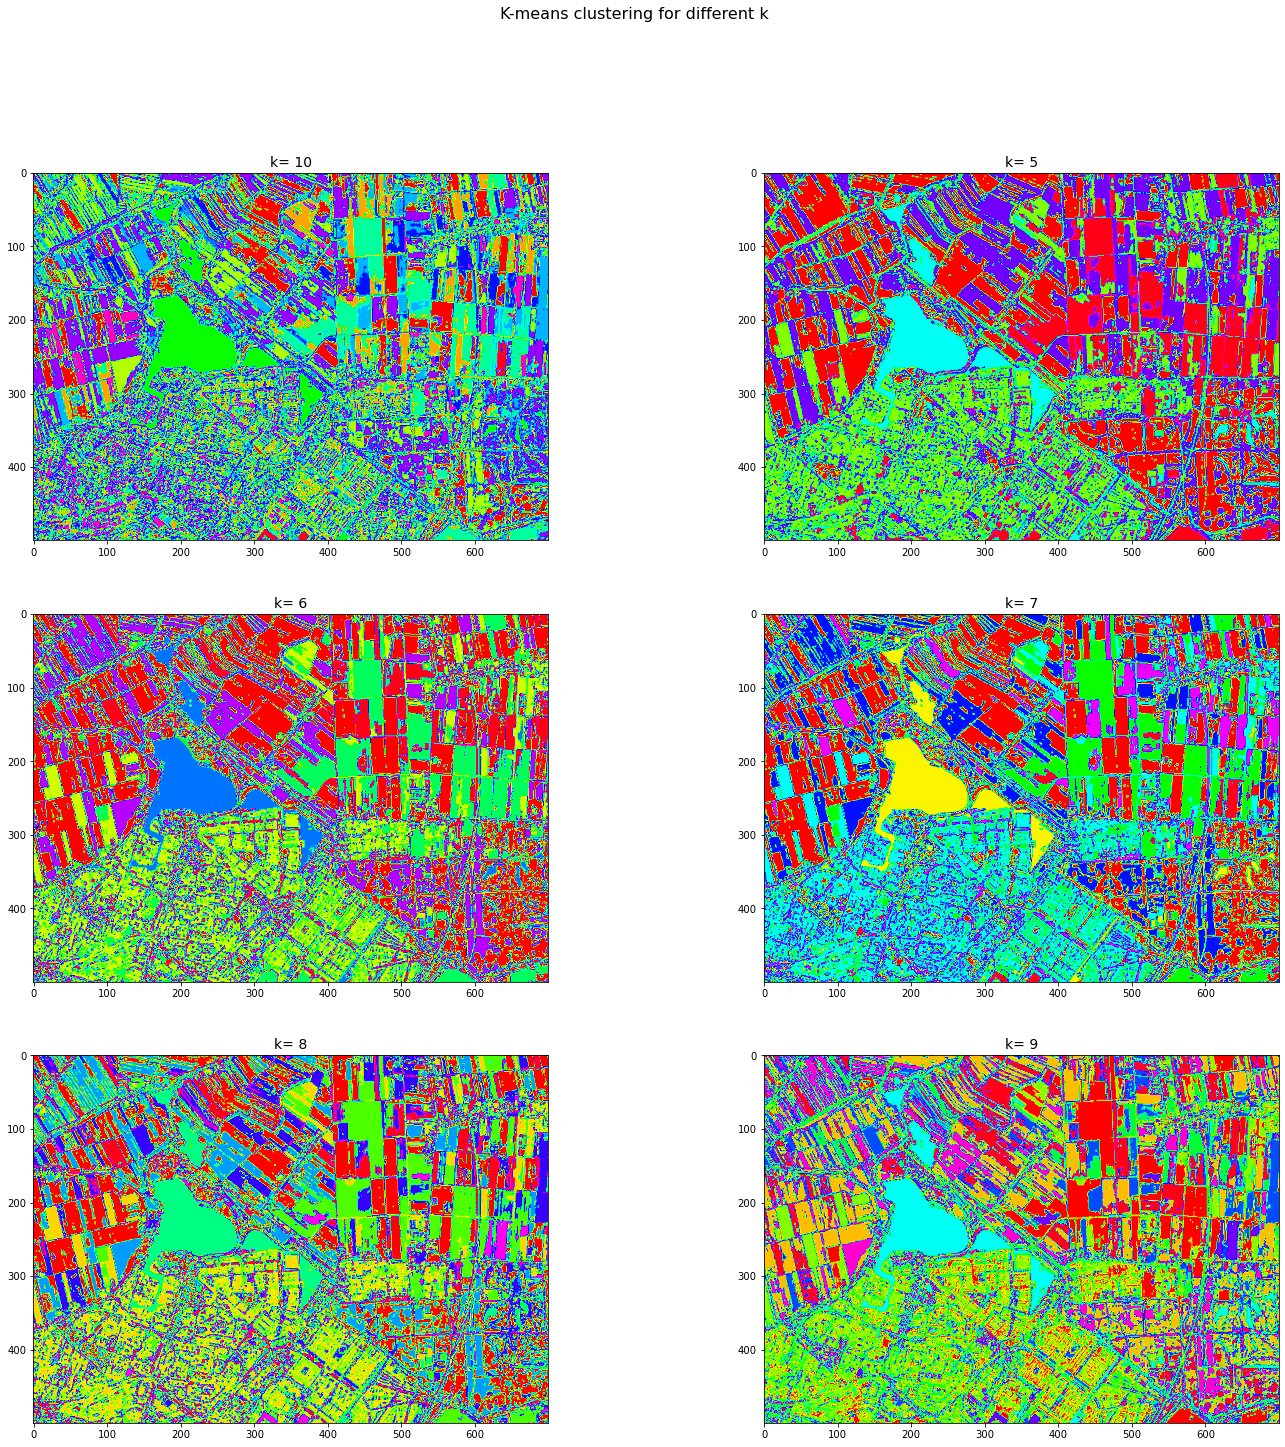

In [19]:
k_path = [os.path.join('./exports/k_means/10m' , i) for i in os.listdir('./exports/k_means/10m') if i.endswith('.tiff')]
f , axs = plt.subplots(3 , 2 , figsize=(24,23))
for _ in range(len(k_path)):
    filenm = k_path[_].split('/')[-1].split('_')[2].strip('.tiff')
    img = rasterio.open(k_path[_], driver='GTiff')
    if _ <2:
        axs[0][_].imshow(img.read(1) , cmap='hsv')
        axs[0][_].set_title('k= {}'.format(filenm) , fontsize='14') 
    elif (_ >= 2) & (_ < 4):
        axs[1][_ - 2].imshow(img.read(1) , cmap='hsv')
        axs[1][_ - 2].set_title('k= {}'.format(filenm), fontsize='14' )
    else:
        axs[2][_ - 4].imshow(img.read(1) , cmap='hsv')
        axs[2][_ - 4].set_title('k= {}'.format(filenm), fontsize='14' )
    img.close()
    del img 
plt.suptitle('K-means clustering for different k', fontsize='16')
plt.show()

## 4.4 Conclusion

# 5. Other classification techinque

# 6. Results and Discussion

## 6.1 Differences with bands

## 6.2 Differences with number of clusters

## 6.3 Differences with spatial resolution of images

### trying to implement the data import from google cloud storage

```python
# filepath = R'https://console.cloud.google.com/storage/browser/gcp-public-data-sentinel-2/L2/tiles/31/U/ET/S2A_MSIL2A_20200530T105031_N0214_R051_T31UET_20200530T134211.SAFE/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R10m/'

# src = rasterio.open(filepath + 'T31UET_20200530T105031_B02_10m.jp2' , driver='JP2OpenJPEG') 
# print(src.profile)
import urllib
fp = 'https://console.cloud.google.com/storage/browser/gcp-public-data-sentinel-2/L2/tiles/31/U/ET/S2A_MSIL2A_20200530T105031_N0214_R051_T31UET_20200530T134211.SAFE/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R10m/T31UET_20200530T105031_B02_10m.jp2'

src = rasterio.open(fp, window=Window(100,100,700,500) )
src
```